# Challenge 8

### Fit to Gaussian peak in 2D plane with extended unbinned likelihood, but with systematic error

Again, we keep track of counts in a `(x, y)` plane. Now, we have some information about `B`. We'll solve this exercise with the Bayesian interpretation of probability (instead of frequentist probability). From a practical point of view, this won't change much the way of solving the exercise, since we'll assume the prior probabilities of our parameters to be constant. Therefore, the posterior probability of the theory parameters (`S`, `B`) will basically be the likelihood function, except we'll have to normalize it over the `S`, `B` space to give it a probability meaning.

We have the same data:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from numba import jit

np.random.seed(
    0
)  # We manually set the seed for reproducible results, this is not required

pos_x = np.array([-9.7, -9.3, -6.9, -6.7, -5.7, -5.1, -2.5, -2.5, -2.3, -2.3, -1.9, -1.9, 
                  -1.9, -1.7, -0.7, -0.7, -0.3, -0.1, 0.1, 0.1, 0.3, 0.5, 0.9, 0.9, 0.9,
                  1.3, 1.7, 2.5, 3.3, 4.7, 5.1, 5.5, 5.9, 7.3, 8.3, 8.7, 8.9, 9.1, 9.5, 9.7])

pos_y = np.array([-2.9, -6.1, 9.5, -3.7, -8.9, -9.5, 0.1, 3.3, -2.9, -1.7, 0.1, 0.3, 7.5, 
                 1.9, -1.5, 0.1, -5.9, 6.9, -0.3, 2.1, 2.9, -1.7, -1.5, -0.3, 0.5, -3.3, 
                 6.3, 0.9, -9.3, -4.1, -9.3, -5.7, 7.5, 5.3, -8.7, 0.5, 2.7, 4.9, -9.5, 8.5])

N = len(pos_x) # Total number of events
print(f"Counts registered: {N}")

print("Count coordinates: ")
for i in range(N):
    print(f"({pos_x[i]}, {pos_y[i]}) ", end="")

Counts registered: 40
Count coordinates: 
(-9.7, -2.9) (-9.3, -6.1) (-6.9, 9.5) (-6.7, -3.7) (-5.7, -8.9) (-5.1, -9.5) (-2.5, 0.1) (-2.5, 3.3) (-2.3, -2.9) (-2.3, -1.7) (-1.9, 0.1) (-1.9, 0.3) (-1.9, 7.5) (-1.7, 1.9) (-0.7, -1.5) (-0.7, 0.1) (-0.3, -5.9) (-0.1, 6.9) (0.1, -0.3) (0.1, 2.1) (0.3, 2.9) (0.5, -1.7) (0.9, -1.5) (0.9, -0.3) (0.9, 0.5) (1.3, -3.3) (1.7, 6.3) (2.5, 0.9) (3.3, -9.3) (4.7, -4.1) (5.1, -9.3) (5.5, -5.7) (5.9, 7.5) (7.3, 5.3) (8.3, -8.7) (8.7, 0.5) (8.9, 2.7) (9.1, 4.9) (9.5, -9.5) (9.7, 8.5) 

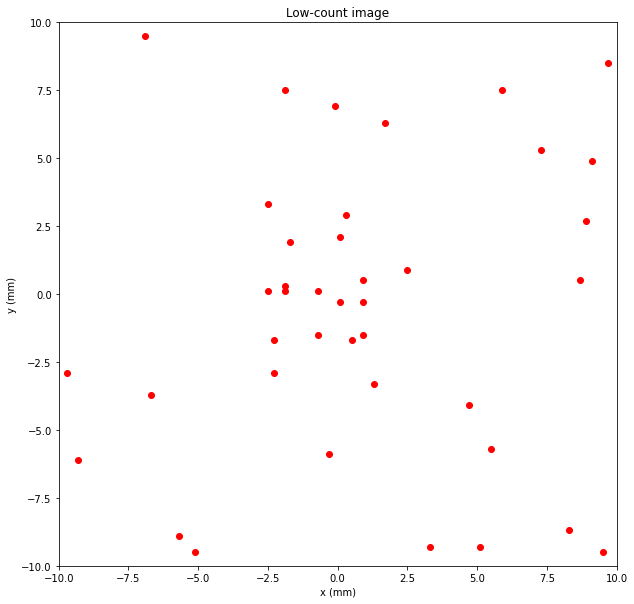

In [2]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

ax.set_title("Low-count image")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

ax.scatter(pos_x, pos_y, color="red")

plt.show()

The distribution of counts for signal over flat background in the plane follows the same 2D Gaussian centered at `(0, 0)` with `sigma2 = 2 mm2`:

In [3]:
@jit
def distr(B, S, x, y, sigma2=2):
    return (B / 400 + (S / 12.5664) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma2)))/(B+S) 

As already mentioned, `B` is known with some systematic uncertainty, `B = 0.05 ± 0.005`. Translating this into our normalised units, `B = 20 ± 2` (multiplying by 400). Since we have a small number of counts in the space, we'll use the unbinned likelihood with an extra Poissonian term (with mean the expected total number of counts, `B+S`) to account for the total number of events registered `N` (again, this means we're assuming the total number `N` is also a random variable and not fixed). We'll incorporate the information about `B` being known by multiplying the likelihood function by a global Gaussian term for `B`, with mean `mean_B = 20` and `sigma_B = 2`. Although in the frequentist approach we'd have followed the same steps, this is more easily justified in Bayesian terms (the information about `B` comes from systematic sources, not the statistical fluctuations of some repeated measurements)

In [4]:
@jit
def gaussian(x, mean, sigma):
    return np.exp(-(x - mean)**2 / (2 * sigma**2)) 

In [5]:
from scipy.stats import poisson

mean_B = 20
sigma_B = 2

def likelihood(B, S):
    res = 1
    for i in range(N):
        res = res*distr(B=B, S=S, x=pos_x[i], y=pos_y[i]) # Unbinned likelihood: product over all the individual events (not bins)
    res = res*poisson(B+S).pmf(N) # Extra Poissonian term with mean B+S
    res = res*gaussian(B, mean_B, sigma_B) # Gaussian term with info about B
    return res

Note that we haven't yet included the normalization over the parameter space of `S`, `B`, and that now we don't apply the `-log()`, since we intend to interpret this as a probability. The normalization factor (integral of the posterior probability = likelihood function in our case, over the parameter space) is just a constant, and doesn't affect the maximum of the likelihood. For practical purposes, we'll calculate this integral (setting cutoffs for `B`, `S`) at the same time we find the values that maximize the likelihood:

In [6]:
def maximize_likelihood(n):
    S_res = 0
    B_res = 0

    max_val = -1e10
    integral = 0
    lower_limit = 0.1 # Instead of 0 to avoid dividing by zero
    upper_limit = 40
    step = (upper_limit - lower_limit) / n

    for S in np.linspace(lower_limit, upper_limit, n):
        for B in np.linspace(lower_limit, upper_limit, n):
            like = likelihood(B=B, S=S)
            integral += like
            if like > max_val:
                max_val = like
                B_res = B
                S_res = S
    
    normalization = integral * step**2
    return max_val, B_res, S_res, normalization


max_val, B_max, S_max, normalization = maximize_likelihood(n=100)

print(f"B={B_max:0.1f}, S={S_max:0.1f}, max_likelihood={max_val}, normalization factor={normalization}")

B=21.1, S=14.2, max_likelihood=4.137796075773232e-100, normalization factor=1.9157675238203974e-98


We now plot the posterior probability (likelihood function over normalization) in two scenarios: fixed `B_max`, varying `S`; varying `B`, fixed `S_max`: 

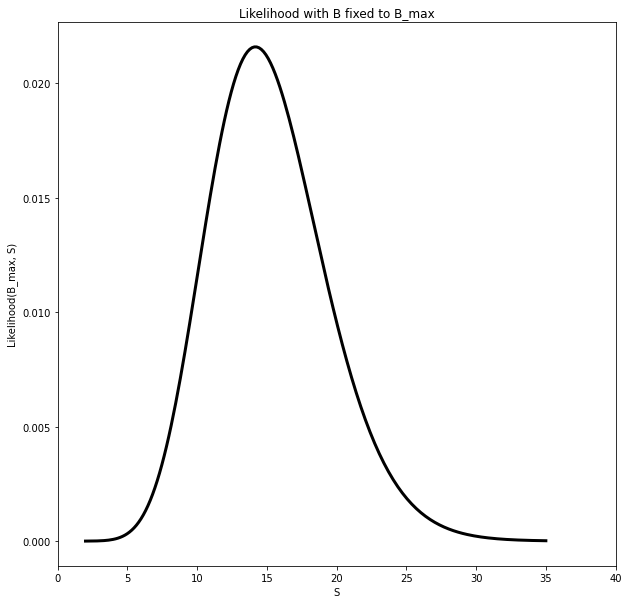

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 40])

ax.set_xlabel("S")
ax.set_ylabel("Likelihood(B_max, S)")
ax.set_title("Likelihood with B fixed to B_max")

S = np.linspace(2, 35, 200)
ax.plot(S, likelihood(B=B_max, S=S)/normalization, color="black", linewidth=3)

plt.show()

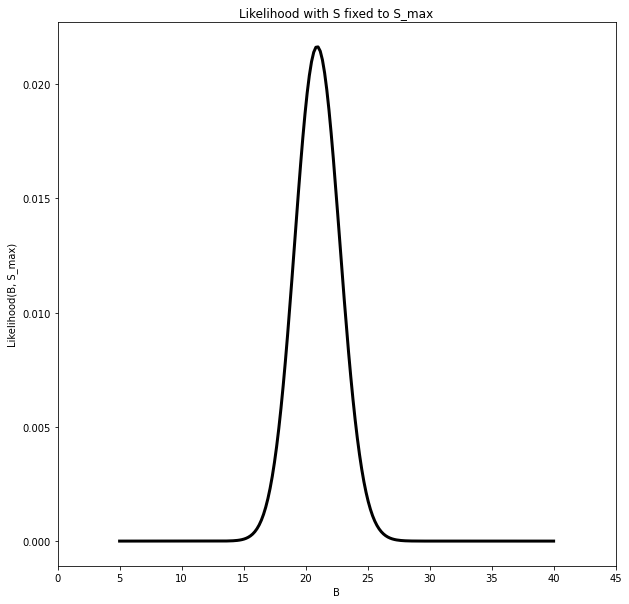

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([0, 45])

ax.set_xlabel("B")
ax.set_ylabel("Likelihood(B, S_max)")
ax.set_title("Likelihood with S fixed to S_max")

B = np.linspace(5, 40, 200)
ax.plot(B, likelihood(B, S=S_max)/normalization, color="black", linewidth=3)

plt.show()

We can also find the uncertainties for both parameters. We'll use the probability interpretation we have for our "likelihood over normalization": we find the interval for each of the plots above such that the integral around the minimum is `0.68` (1 sigma case): 

In [9]:
integral = 0
lower_limit = 0.1 # Instead of 0 to avoid dividing by zero
upper_limit = 40
step = (upper_limit - lower_limit) / 100

for S in np.linspace(lower_limit, upper_limit, 100):
    for B in np.linspace(lower_limit, upper_limit, 100):
        like = likelihood(B=B, S=S)
        integral += like
print(integral*step**2/normalization)
print(normalization)

def find_interval(n=100):
    
    sigma = 0.68
    lower_limit = 0.1 # Instead of 0 to avoid dividing by zero
    upper_limit = 40
    step = (upper_limit - lower_limit) / n
    
    # B error: we let B vary
    step1 = (B_max - lower_limit) / n
    step2 = (upper_limit - B_max) / n
    
    integral = 0
    for s in np.linspace(lower_limit, upper_limit, n):
        integral += likelihood(B=B_max, S=s)*step/normalization
    for i in np.linspace(lower_limit, B_max, n):
        integral += likelihood(B=i, S=S_max)*step1/normalization
        if integral > sigma/2:
            B_lower_limit = B_max - i
            break
    
    integral = 0
    for s in np.linspace(lower_limit, upper_limit, n):
        integral += likelihood(B=B_max, S=s)*step/normalization
    for i in reversed(np.linspace(B_max, upper_limit, n)):
        integral += likelihood(B=i, S=S_max)*step2/normalization
        if integral > sigma/2:
            B_upper_limit = i - B_max
            break
    
    B_error = max(B_lower_limit, B_upper_limit) # We ensure an integral >= 0.68
    
    
    # S error: we let S vary
    step1 = (S_max - lower_limit) / n
    step2 = (upper_limit - S_max) / n
    
    integral = 0
    for b in np.linspace(lower_limit, upper_limit, n):
        integral += likelihood(B=b, S=S_max)*step/normalization
    for i in np.linspace(lower_limit, S_max, n):
        integral += likelihood(B=B_max, S=i)*step1/normalization
        if integral > sigma/2:
            S_lower_limit = S_max - i
            break
    
    integral = 0
    for b in np.linspace(lower_limit, upper_limit, n):
        integral += likelihood(B=b, S=S_max)*step/normalization
    for i in reversed(np.linspace(S_max, upper_limit, n)):
        integral += likelihood(B=B_max, S=i)*step2/normalization
        if integral > sigma/2:
            S_upper_limit = i - S_max
            break
    
    S_error = max(S_lower_limit, S_upper_limit) # We ensure an integral >= 0.68
    
    return B_error, S_error


B_error, S_error = find_interval(n=100)

print(f"Uncertainty of B = {B_error:0.1f}, confidence interval: {B_max:0.1f} ± {B_error:0.1f}")
print(f"Uncertainty of S = {S_error:0.1f}, confidence interval: {S_max:0.1f} ± {S_error:0.1f}")

1.0
1.9157675238203974e-98


UnboundLocalError: local variable 'B_lower_limit' referenced before assignment

Finally, we can plot some level curves of our fitted 2D function:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

ax.set_title("Low-count image")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

ax.scatter(pos_x, pos_y, color="red")

xlist = np.linspace(-4.0, 4.0, 100)
ylist = np.linspace(-4.0, 4.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = distr(B_max, S_max, X, Y, sigma2=2)
ax.contour(X, Y, Z, colors="black")

plt.show()